In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModel
import os
import numpy as np
import torch.nn as nn
import ast
import sys
sys.path.append('..')
os.chdir('..')

from ast2vec import tree as tree
from ast2vec.ast2vec import encode_trees, load_model
from ast2vec import tree_grammar as tree_grammar
from ast2vec import python_ast_utils
from ast2vec.python_ast_utils import *

2023-04-29 18:53:38.066965: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [52]:
!wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2023-04-29 19:14:23--  https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10352 (10K) [text/plain]
Saving to: ‘unixcoder.py’

unixcoder.py        100%[===================>]  10.11K  --.-KB/s    in 0.006s  

2023-04-29 19:14:23 (1.63 MB/s) - ‘unixcoder.py’ saved [10352/10352]



In [66]:
from utils import set_random_seed
from unixcoder import UniXcoder
from sklearn.metrics.pairwise import cosine_similarity

set_random_seed(404)

## Prepare Models

In [98]:
def compute_embeddings(model, codes):
    embeddings = []
    for code in codes:
        embeddings.append(model.get_embedding(code))
    return embeddings

class CodeBert:
    def __init__(self, name):
        self.tokenizer = AutoTokenizer.from_pretrained(name)
        self.model = AutoModel.from_pretrained(name)

    def get_embedding(self, code):
        code_tokens=self.tokenizer.tokenize(code, max_length=1024)
        tokens=[self.tokenizer.cls_token, self.tokenizer.sep_token] + code_tokens + [self.tokenizer.eos_token]
        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        context_embeddings=self.model(torch.tensor(tokens_ids)[None,:])[0]
        return context_embeddings[:,0,:].squeeze().detach().numpy()
    
class UnixCoder:
    def __init__(self):
        self.model = UniXcoder("microsoft/unixcoder-base")
        
    def get_embedding(self, code):
        tokens_ids = self.model.tokenize(codes, max_length=512, mode="<encoder-decoder>")
        tokens_embeddings, max_func_embedding = self.model(torch.tensor(tokens_ids))
        return max_func_embedding.squeeze().detach().numpy()
    
    
class Ast2Vec:
    def __init__(self):
        self.model = load_model('ast2vec/ast2vec.pt')
    
    def convert_to_tree(self, src):
        parser = tree_grammar.TreeParser(grammar)
        try:
            ast_tree = ast.parse(src, mode='exec')
            x = ast_to_tree(ast_tree)
            parser.parse_tree(x)
            return x
        except:
            return None
    
    def get_embedding(self, code):
        tree = self.convert_to_tree(code)
        X = encode_trees(self.model, [tree])
        return X.squeeze()

In [99]:
true_pairs = [
(""" 
a = int(input())
b = int(input())
""",
"""
c = int(input())
d = int(input())
"""), # names changing
("""
a = int(input())
for i in range(a):
    print(i)
""",
"""
a = int(input())
b = 1
for i in range(a):
    print(i)
"""), # noise variables
("""
if a > b:
    print(a)
""",
"""
if b < a:
    print(a)
"""), # if swapping
("""
if a > b:
    print(a)
""",
"""
if a > b and True:
    print(a)
"""), # if noising
("""
for i in range(10):
    print(i)
""",
"""
i = 0
while i < 10:
    print(i)
"""), # loop contruction changing
]

In [100]:
false_pairs = [
(""" 
a = int(input())
""",
"""
c = int(input())
d = int(input())
"""), # duplicate constructions
("""
a = int(input())
for i in range(a):
    print(i)
""",
"""
a = int(input())
for i in range(a-1):
    print(i)
"""), # incorrect loop condition
("""
if a > b:
    print(a)
""",
"""
if b > a:
    print(a)
"""), # incorrect if condition
("""
a = int(input())
for i in range(a):
    print(i)
""",
"""
for i in range(a):
    print(i)
"""), # forgotting input
("""
if a > 10:
    print(a)
    print(10)
""",
"""
if a > 10:
    print(a)
print(10)
"""), # indent changing
]

In [105]:
models = {
    'CodeBert' : CodeBert('microsoft/codebert-base'),
    'GraphCodeBert' : CodeBert('microsoft/graphcodebert-base'),
    'UnixCoder' : UnixCoder(),
    'Ast2Vec' : Ast2Vec(),
}

Some weights of the model checkpoint at microsoft/graphcodebert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to

In [187]:
from scipy.stats import pearsonr

In [206]:
d = {
    'model_name' : [m for m in models.keys()],
    'true_pairs' : [],
    'false_pairs' : [],
    'num_of_params' : []
}
def compute_embeddings(pairs, model):
    cos_sims = []
    for (x, y) in pairs:
        x_emb = model.get_embedding(x)
        y_emb = model.get_embedding(y)
        # cos_sims.append(pearsonr(x_emb, y_emb).statistic)
        cos_sims.append(cosine_similarity(x_emb[None,:], y_emb[None,:])[0][0])
    return np.mean(cos_sims)

for (model_name, model) in tqdm(models.items()):
    d['true_pairs'].append(compute_embeddings(true_pairs, model))
    d['false_pairs'].append(compute_embeddings(false_pairs, model))
    d['num_of_params'].append(sum(p.numel() for p in model.model.parameters() if p.requires_grad))

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.63s/it]


In [207]:
result = pd.DataFrame(d)
result['false_pairs'] = 1 - result['false_pairs'].astype(np.float16)
result['true_pairs'] = result['true_pairs'].astype(np.float16)

In [202]:
result['score'] = (result['true_pairs'] + result['false_pairs'])/2

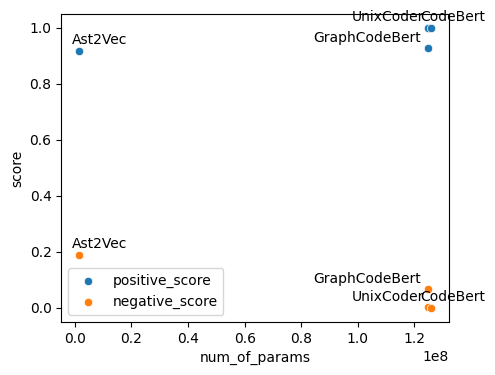

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))

ax = sns.scatterplot(x="num_of_params", y="true_pairs", data=result, label='positive_score')
ax = sns.scatterplot(x="num_of_params", y="false_pairs", data=result,label='negative_score')
aligment = ['left','right','right','left']

for ax_idx, column in enumerate(['true_pairs','false_pairs']):
    for i, row in result.iterrows():
        ax.annotate(row["model_name"], xy=(row["num_of_params"], row[column]), xytext=(-5,5),
                    textcoords="offset points", fontsize=10, horizontalalignment=aligment[i])

plt.ylabel('score')
plt.legend()
plt.savefig('embedding_scores_pearson.png', facecolor='white')